# Playground notebook for testing the generation of networks from connectivity and nonlinearity matrices

In [ ]:
import torch
import numpy as np
from torch import nn
from scipy.sparse.csgraph import shortest_path
from comp_capacity.repr.network import MatrixContainer
from torch.distributions.multinomial import Multinomial

In [2]:
def sample_nonlinearity_matrix(
    n_nodes: int = 2,
    n_nonlinearities: int = 2,
    weighting: torch.Tensor | None = None,
    seed: int | None = None,
    device: str | None = None,
) -> torch.Tensor:
    """
    Generate a random nonlinearity matrix of shape (n_nodes, n_nonlinearities).

    Args:
        n_nodes (int): Number of nodes.
        n_nonlinearities (int): Number of nonlinearities.
        weighting (torch.Tensor, optional): Weights for each nonlinearity.
            If None, uniform weights are used.
        seed (int, optional): Random seed for reproducibility.
        device (str, optional): Device to create the tensor on. Defaults to None.
    Returns:
        torch.Tensor: One-hot encoded nonlinearity matrix with shape (n_nodes, n_nonlinearities).
    """
    n_nodes += 2  # add input and output nodes
    if seed is not None:
        torch.manual_seed(seed)

    if weighting is None:
        weighting = torch.ones(n_nonlinearities, device=device) / n_nonlinearities

    sampler = Multinomial(probs=weighting)

    return sampler.sample((n_nodes,)).to(device=device, dtype=torch.bool)


def add_connectivity(adj_matrix, orig_mask, index=0):
    """
    Ensure every node is reachable from the `index` node by repeatedly
    adding one edge from the reachable set to the first unreachable node.
    """
    adj_matrix = adj_matrix.clone()
    orig_mask = orig_mask.cpu().numpy() > 0
    while True:
        # 1) compute reachability
        dist = shortest_path(adj_matrix.cpu().numpy(), directed=True, indices=index)

        unreachable = np.where(np.isinf(dist))[0]
        if index == 0:
            unreachable = unreachable[unreachable != len(adj_matrix) - 1]
        elif index == len(adj_matrix) - 1:
            unreachable = unreachable[unreachable != 0]

        # 2) done?
        if len(unreachable) == 0:
            break

        node = unreachable[0]
        mask = np.isfinite(dist) & orig_mask[:, node]

        # 3) guard against empty mask
        if not mask.any():
            raise RuntimeError(f"No reachable origin to connect node {node!r}")

        # 4) sample exactly one new incoming edge
        probs = torch.tensor(mask, dtype=torch.float, device=adj_matrix.device)
        sample_connection = (
            Multinomial(total_count=1, probs=probs).sample().to(dtype=torch.bool)
        )

        # 5) add it
        adj_matrix[:, node] = (sample_connection | adj_matrix[:, node])

    return adj_matrix


def sample_connectivity(
    n_nodes: int = 2,
    p: float = 0.5,
    recurrent: bool = False,
    seed: int | None = None,
    device: str | None = None,
):
    """
    Generate a random connectivity matrix of shape (n_nodes + 2, n_nodes + 2).
    The first and last nodes are the input and output nodes, respectively.
    The connectivity is generated using a Bernoulli distribution with probability p.
    The function ensures that each node is reachable from the input node and
    the output node is reachable from all nodes (except the input).

    Args:
        n_nodes (int): Number of nodes (not including input and output nodes).
        p (float): Probability of connection between nodes.
        recurrent (bool): If True, allows recurrent connections.
        seed (int, optional): Random seed for reproducibility.
        device (str, optional): Device to create the tensor on. Defaults to None.
    """

    n_nodes += 2  # add input and output nodes

    if seed is not None:
        torch.manual_seed(seed)

    probs = torch.full((n_nodes, n_nodes), fill_value=p, device=device)
    probs[:, 0] = 0  # nothing should connect to the input node
    probs[-1] = 0  # output node should not connect to anything
    if not recurrent:
        # Ensure no self-loops and no backward connections
        probs = torch.triu(probs, diagonal=1)
        probs[0, 1] = 1  # ensure input node connects to first hidden node

    sample = torch.bernoulli(probs).to(dtype=torch.bool)

    # make sure each node is reachable from the input node
    sample = add_connectivity(sample, probs, index=0)

    # make sure output node is reachable from all nodes (except input)
    sample = add_connectivity(sample.T, probs.T, index=n_nodes - 1).T

    return sample

In [3]:
nonlinearity_map = {
    0: nn.ReLU,
    1: nn.Tanh,
    2: nn.LeakyReLU,
    3: nn.Identity,
}

## Sample a connectivity matrix and nonlinearity matrix

In [4]:
seed = 0
n_nodes = 3
n_nonlinearities = 4
# nonlinearities can be: ReLU, Tanh, LeakyReLU, Identity IN THAT ORDER

In [5]:
# mps device on macOS for faster computation
if torch.backends.mps.is_available():
    device = "mps"
else:
    # fall back to CPU
    device = "cpu"

---- seed=0 ----


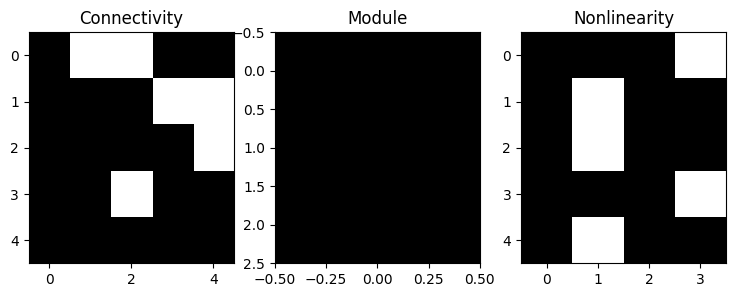

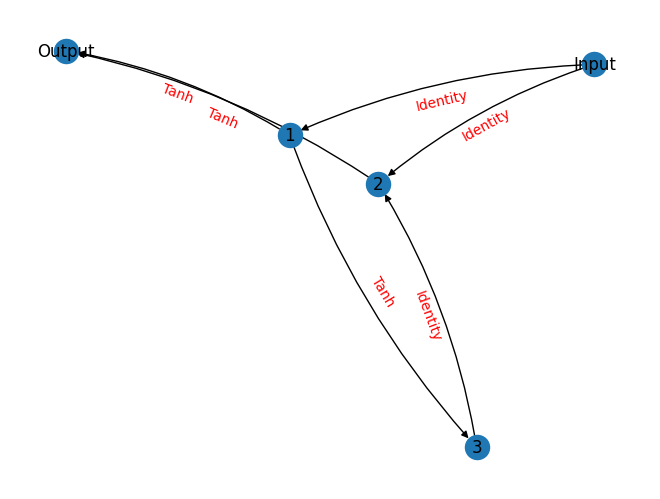

---- seed=1 ----


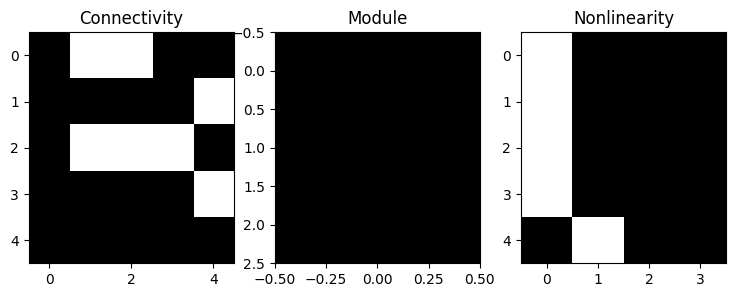

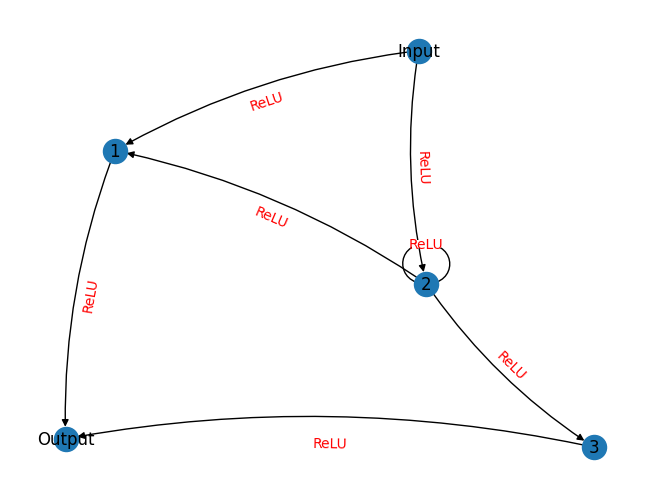

---- seed=2 ----


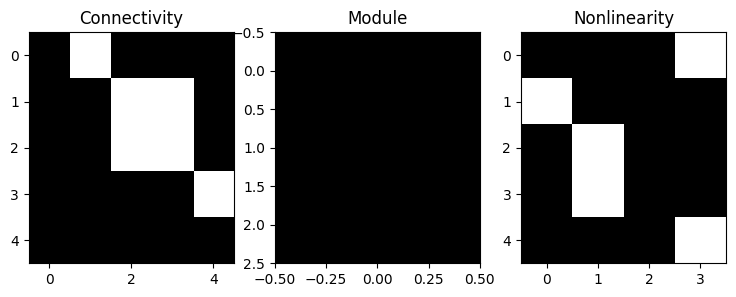

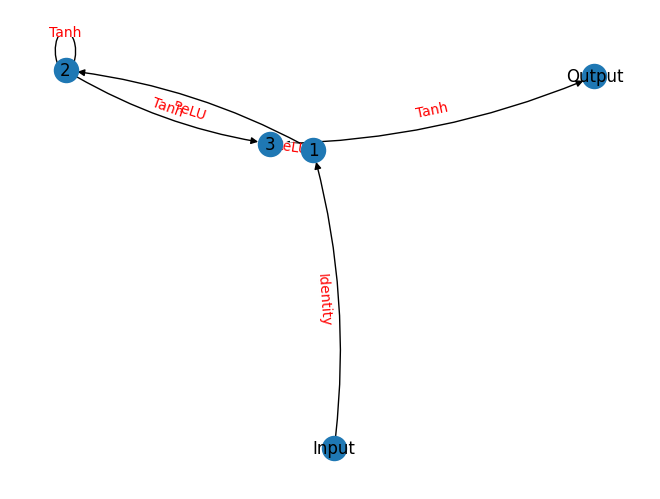

---- seed=3 ----


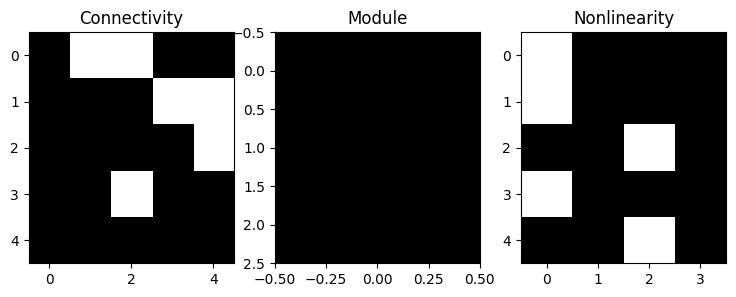

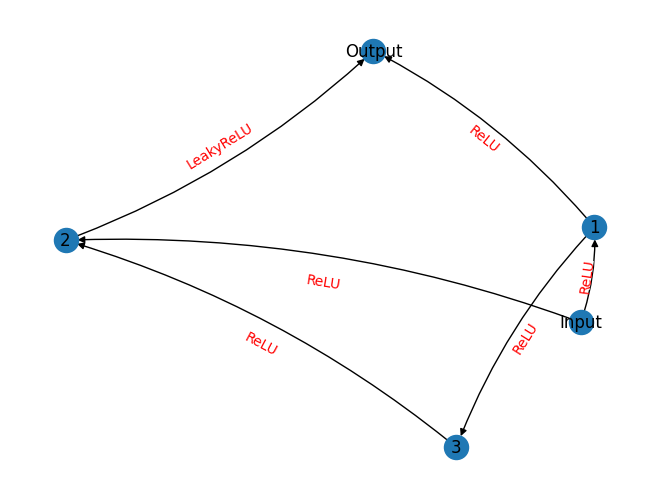

---- seed=4 ----


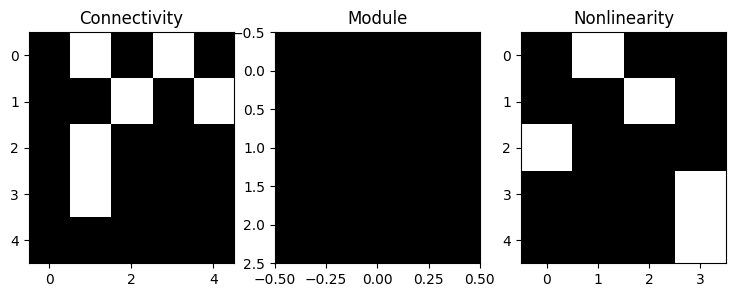

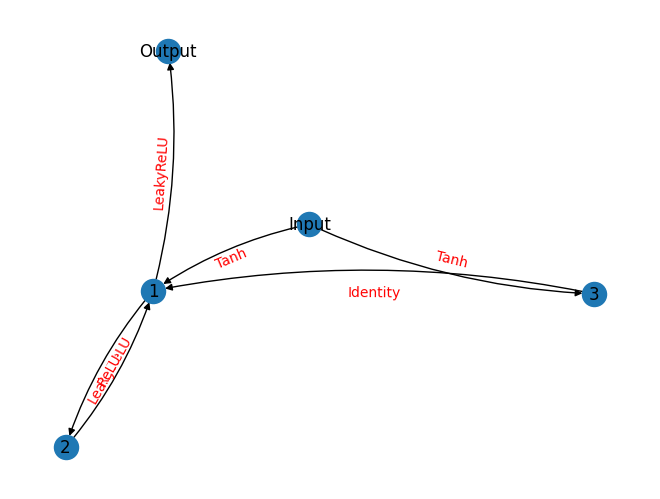

---- seed=5 ----


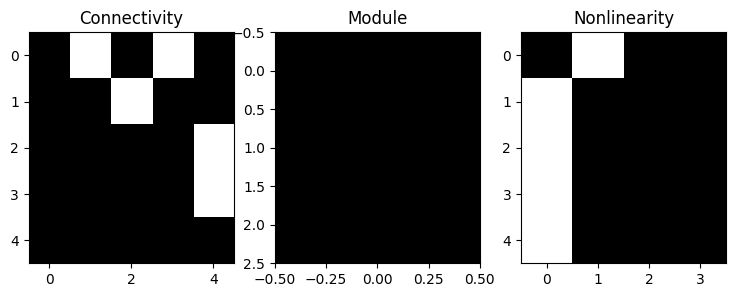

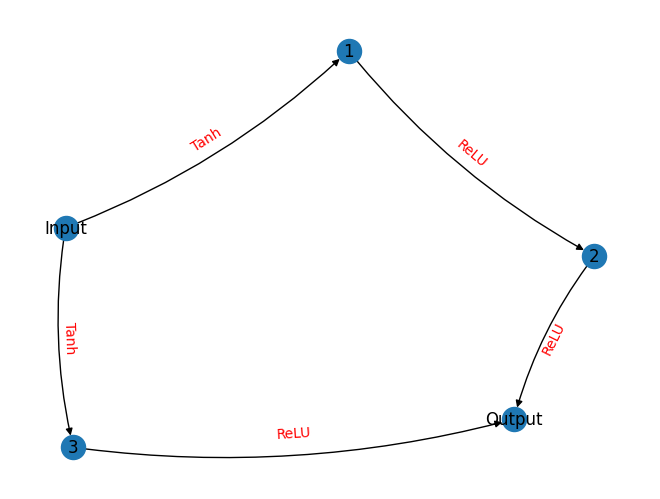

---- seed=6 ----


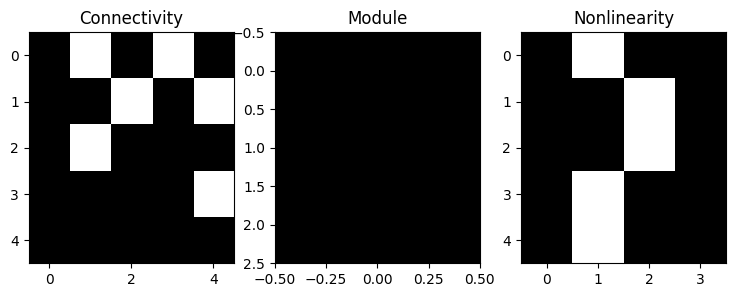

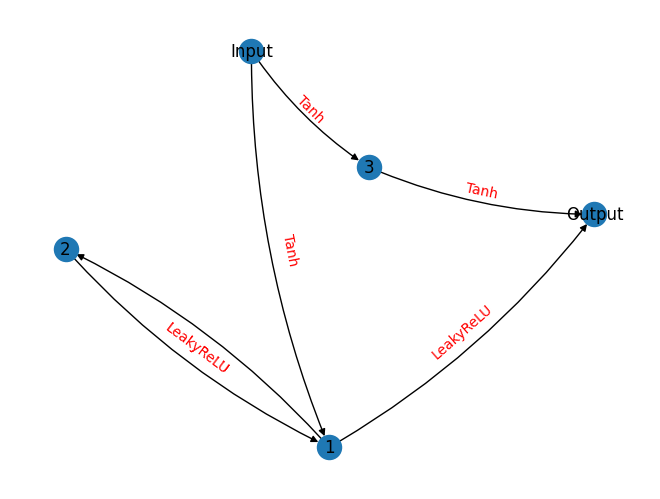

---- seed=7 ----


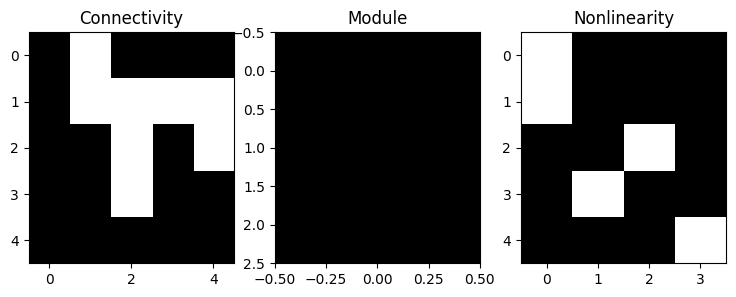

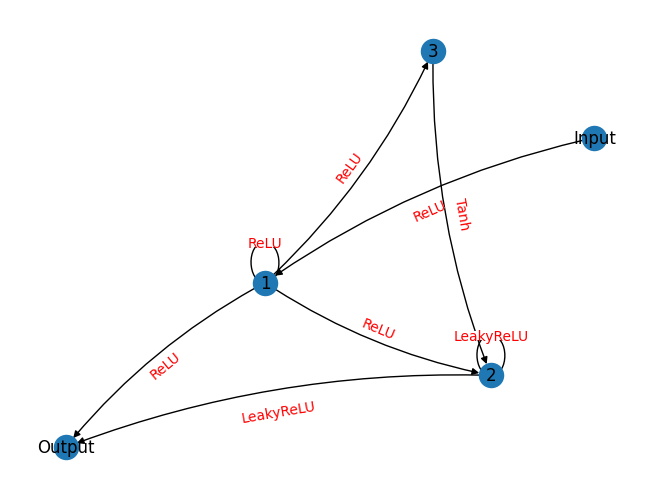

---- seed=8 ----


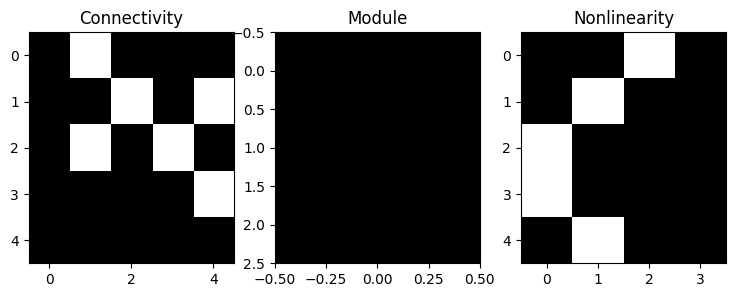

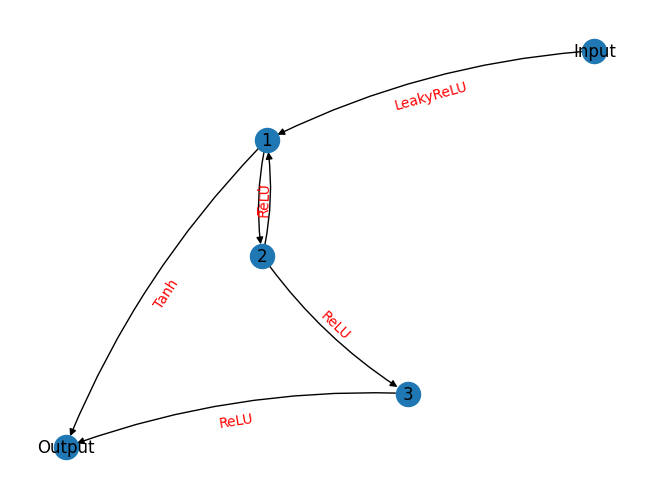

---- seed=9 ----


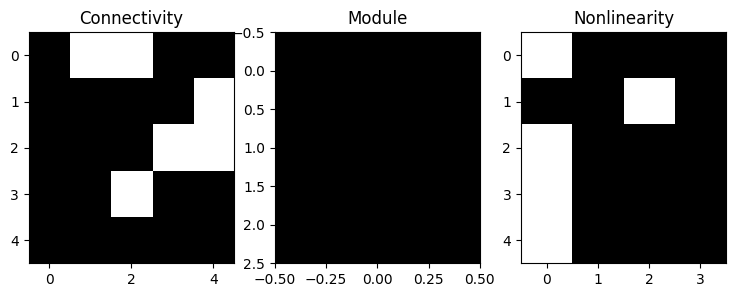

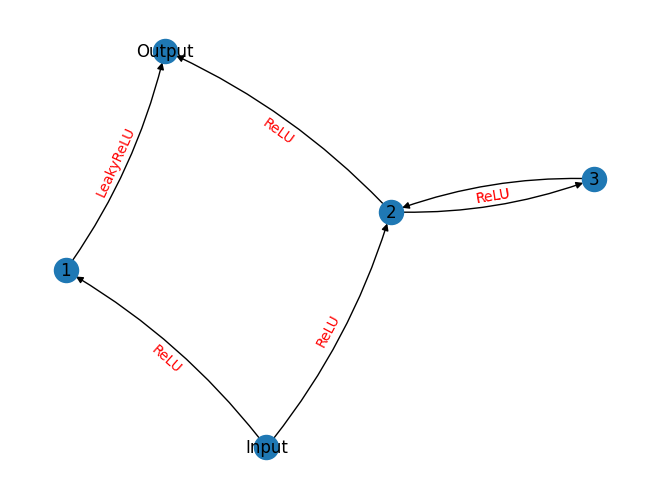

In [6]:
for seed in range(10):
    print(f"---- {seed=} ----")
    # set module matrix to just "neurons" for now
    module = torch.ones((n_nodes, 1), dtype=torch.bool, device=device)
    connectivity = sample_connectivity(n_nodes, p=0.1, seed=seed, device=device, recurrent=True)
    nonlinearity = sample_nonlinearity_matrix(
        n_nodes,
        n_nonlinearities,
        weighting=torch.tensor([2, 2, 1, 0.5]),
        seed=seed,
        device=device,
    )
    container = MatrixContainer(connectivity=connectivity, module=module, nonlinearity=nonlinearity)
    container.plot_matrices()
    container.plot_graph_representation()

## Example function for generating network from connectivity

In [7]:
def generate_network(
    matrices: MatrixContainer,
    input_dim: int,
    output_dim: int,
    device: str | None = None,
) -> nn.Module:
    """
    Generate a network from the given matrices.

    Args:
        matrices (MatrixContainer): The container holding the connectivity and nonlinearity matrices.

    Returns:
        nn.Module: The generated network.
    """
    network = nn.ModuleDict()

    # for each node N, find number of input connections:
    for N, outputs in enumerate(matrices.connectivity):
        inputs = matrices.connectivity[:, N]

        # find nonlinearity from map - argmax specifies location of nonlinearity in one-hot encoded matrix
        nonlinearity_fun = nonlinearity_map[
            matrices.nonlinearity[N].cpu().numpy().argmax()
        ]

        if N == 0:
            layer = nn.Linear(input_dim, outputs.sum())
        elif N == len(matrices.connectivity) - 1:
            layer = nn.Linear(inputs.sum(), output_dim)
        else:
            layer = nn.Linear(inputs.sum(), outputs.sum())
        network[f"{N}"] = nn.Sequential(
            layer,
            nonlinearity_fun(),
        )
    return network.to(device)


def forward(
    network: nn.Module,
    adj_matrix: torch.Tensor,
    X: torch.Tensor,
    state: torch.Tensor | None = None,
    recurrent: bool = False,
) -> torch.Tensor:
    """
    Forward pass through the network.
    Args:
        network (nn.Module): The network to forward through.
        X (torch.Tensor): Input tensor.
    Returns:
        torch.Tensor: Output tensor.
    """

    if state is None:
        state = torch.zeros(adj_matrix.shape, device=adj_matrix.device)

    # run through input node:
    out = network[f"{0}"](X)

    state[0, adj_matrix[0]] = network[f"{0}"](X)

    for node in range(1, len(adj_matrix) - 1):
        # node receives inputs from following nodes:
        inputs = adj_matrix[:, node]

        tmp = network[f"{node}"](state[inputs, node])
        state[node, adj_matrix[node]] = tmp

    # run through output node:
    node = len(adj_matrix) - 1
    inputs = adj_matrix[:, node]
    out = network[f"{node}"](state[inputs, node])

    if recurrent:
        return out, state

    return out

In [8]:
network = generate_network(container, 5, 2, device=device)

In [9]:
output, state = forward(network, container.connectivity, torch.randn((1, 5), device=device), recurrent=True)

In [10]:
state

tensor([[0.0000, 0.2313, 0.2234, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.6532],
        [0.0000, 0.0000, 0.0000, 0.6500, 0.2689],
        [0.0000, 0.0000, 0.5021, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]], device='mps:0',
       grad_fn=<CopySlices>)

In [11]:
output

tensor([0.1224, 0.2897], device='mps:0', grad_fn=<ReluBackward0>)